# DESI Seeing Model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import desimodel.seeing

Plot the probability distribution of DESI zenith seeing at 6355A and calculate seeing & delivered image qualitity statistics.  Note that the median DIQ found below matches the value (1.33") quoted in [DESI-doc-311](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=311).

  Mean seeing = 1.726 arcsec
     Mean DIQ = 1.887 arcsec
Median seeing = 1.200 arcsec
   Median DIQ = 1.334 arcsec


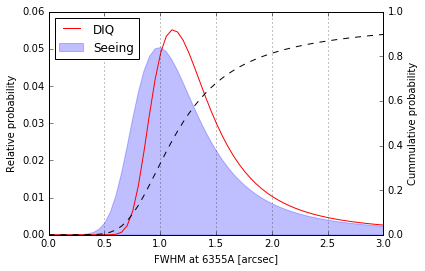

In [3]:
def plot_seeing_pdf(save=None):
    
    # Tabulate the PDF model.
    fwhm = np.linspace(0., 10., 200)
    seeing_pdf = desimodel.seeing.relative_probability(fwhm)
    diq_pdf = desimodel.seeing.relative_probability(fwhm, blur_arcsec=0.)
    
    # Calculate mean and percentiles.
    mean_seeing = (fwhm * seeing_pdf).sum() / seeing_pdf.sum()
    print '  Mean seeing = {:.3f} arcsec'.format(mean_seeing)

    mean_diq = (fwhm * diq_pdf).sum() / diq_pdf.sum()
    print '     Mean DIQ = {:.3f} arcsec'.format(mean_diq)
    
    seeing_cdf = np.cumsum(seeing_pdf)
    seeing_cdf /= seeing_cdf[-1]
    median_seeing = np.interp(0.5, seeing_cdf, fwhm)
    print 'Median seeing = {0:.3f} arcsec'.format(median_seeing)

    diq_cdf = np.cumsum(diq_pdf)
    diq_cdf /= diq_cdf[-1]
    median_diq = np.interp(0.5, diq_cdf, fwhm)
    print '   Median DIQ = {:.3f} arcsec'.format(median_diq)
    
    plt.fill_between(fwhm, seeing_pdf, color='b', alpha=0.25, label='Seeing')
    plt.plot(fwhm, diq_pdf, 'r-', label='DIQ')

    plt.xlabel('FWHM at 6355A [arcsec]')
    plt.ylabel('Relative probability')
    plt.grid(axis='x')
    
    plt.legend(loc='upper left')

    rhs = plt.twinx()
    rhs.plot(fwhm, seeing_cdf, 'k--')
    rhs.set_ylabel('Cummulative probability')
    rhs.set_xlim(0, 3)
    
    if save:
        plt.savefig(save)
    
plot_seeing_pdf()

Generate random seeing samples and check their distributions:

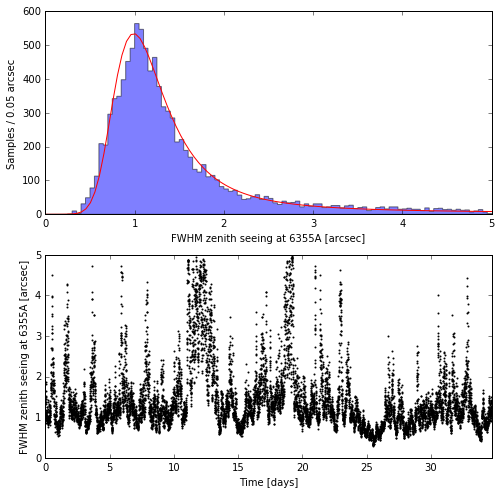

In [4]:
def test_sampler(n_sample=10000, dt_sec=300, max_seeing=5., bins=100,
                 seed=123, save=None):
    
    seeing = desimodel.seeing.sample(n_sample, dt_sec, max_seeing, seed)
    
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    
    # Plot samples histogram
    ax[0].hist(seeing, bins, range=(0., max_seeing),
               histtype='stepfilled', color='b', alpha=0.5)
    # Overlay model PDF.
    x = np.linspace(0, max_seeing, bins)
    y = desimodel.seeing.relative_probability(x) * n_sample
    ax[0].plot(x, y, 'r-')
    ax[0].set_xlabel('FWHM zenith seeing at 6355A [arcsec]')
    ax[0].set_ylabel('Samples / {0:.2f} arcsec'.format(max_seeing / bins))
    ax[0].set_xlim(0., max_seeing)
    
    # Plot time series.
    t = np.arange(n_sample) * dt_sec / (24. * 3600.)
    ax[1].scatter(t, seeing, s=1, c='b')
    ax[1].set_xlabel('Time [days]')
    ax[1].set_ylabel('FWHM zenith seeing at 6355A [arcsec]')
    ax[1].set_xlim(t[0], t[-1])
    ax[1].set_ylim(0., max_seeing)
    
    if save:
        plt.savefig(save)
    
test_sampler()

Benchmark the time required to simulate a full 5-year time series of seeing values at 5-minute intervals.

In [5]:
import time

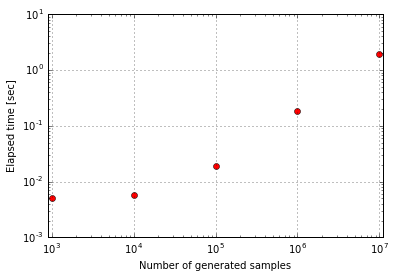

In [6]:
def benchmark_study(min_pow10=3, max_pow10=7):
    n_pow10 = max_pow10 - min_pow10 + 1
    results = np.empty((n_pow10, 2))
    for i, pow10 in enumerate(range(min_pow10, max_pow10 + 1)):
        n_sample = int(10 ** pow10)
        start = time.time()
        samples = desimodel.seeing.sample(n_sample)
        elapsed = time.time() - start
        assert samples.shape == (n_sample,)
        results[i] = n_sample, elapsed

    plt.plot(results[:, 0], results[:, 1], 'ro')
    plt.xlabel('Number of generated samples')
    plt.ylabel('Elapsed time [sec]')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.9 * results[0, 0], 1.1 * results[-1, 0])
    plt.grid()
    
benchmark_study()